<a href="https://colab.research.google.com/github/khaledmohamed00/Yearbook_dating/blob/master/yearbook_dating.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Yearbook Datting
##INTRODUCTION
![alt text](https://people.eecs.berkeley.edu/~shiry/projects/yearbooks/images/decade_averages_labelled.png) 
-This notebook demonstrates an approach on  creating deep learning model that can predict the date of female portraits and trying to answer the question(is there enough decade-specific visual patterns to be able to predict the year in which a portrait of a face was taken by using deep learning ?).<br />
-The inspiration of the notebook is A Century of Portraits:A Visual Historical Record of American High School Yearbooks paper
[Yearbooks paper](https://arxiv.org/pdf/1511.02575.pdf)


##Overview the Data Set
* The yearbook dataset is Collection of 949 scanned
yearbooks from American high schools ranging from 1905-2013 across 128 schools in 27 states
* 37,921 photographs that depict individuals from 814 yearbooks across 115 high schools in 26 states.
* 53.4% of the photos are of women, and 46.6%
are of men. 

## Major libraries and Tools used 
* Tensorflow 1.13.1 (Deep Learning Framework)
* openCv (Computer Vision Libary for image processing)
* Albumentations (Image Augmentation library)[Albumentations GitHub](https://github.com/albumentations-team/albumentations)


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!tar -xf '/content/drive/My Drive/faces_aligned_small_mirrored_co_aligned_cropped_cleaned.tar.gz'

In [0]:
!pip install tensorflow-gpu==1.13.1

     |████████████████████████████████| 345.2MB 45kB/s 
     |████████████████████████████████| 368kB 38.5MB/s 
     |████████████████████████████████| 3.2MB 34.5MB/s 
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 1.13.1 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 1.13.0 which is incompatible.
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0


In [0]:
!pip install -U git+https://github.com/albu/albumentations


  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-v0xoy775
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-v0xoy775
     |████████████████████████████████| 634kB 2.8MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.4-cp36-none-any.whl size=61995 sha256=78b9327182ae285cadd3bc87a353afb3f785437f72b63677b89dc719d5b49183
  Stored in directory: /tmp/pip-ephem-wheel-cache-us96s0py/wheels/45/8b/e4/2837bbcf517d00732b8e394f8646f22b8723ac00993230188b
  Created wheel for imgaug: filename=imgaug-0.2.6-cp36-none-any.whl size=654020 sha256=a123c95e4d9b84665af6731c015edfc34e8bed8afbc0a6e76608a8e81d9ea2dc
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built albumentations imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
  

### Helper functions

In [0]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd

def load_images(img_ids,img_dim):
   imgs=[]
   #dim=(96,96)
   for img_id in img_ids:
      img=cv2.imread(img_id)
      #img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
      #img=(img-imgs_mean)/255.0
      img = cv2.resize(img, img_dim, interpolation = cv2.INTER_AREA)
      img=img.reshape([img_dim[0],img_dim[1],3])
      imgs.append(img)
   
   imgs=np.array(imgs)
   
   return imgs

def calculate_images_mean(input_images):
    
    summ=input_images.sum(axis=0)
    summ=summ.sum(axis=0)
    summ=summ.sum(axis=0)
    mean=summ/(input_images.shape[0]*input_images.shape[1]*input_images.shape[2])
    
    return mean
   

def image_pre_processing(images,imgs_mean):
    images=(images-imgs_mean)/255.0
    
    return images 

def load_labels_one_hot_encoding(img_years,no_labels):
 
    labels=[]    
    min_year = 28
    for year in img_years:
        one_hot=np.zeros([no_labels])
        year = str(year).split('_')[0]
        if year[0] == str(1): # 20th century
           label = int(year[-2:]) - min_year 
        else: # 21st century
           label = int(year[-2:]) + (100 - min_year)
        one_hot[label]=1
        labels.append(one_hot)
    labels=np.array(labels)    
    
    return labels        

## Exploring the Dataset
* I am using images from train_F.txt for training the model and test_F.txt for Testing 


In [0]:
path="/content/faces_aligned_small_mirrored_co_aligned_cropped_cleaned/"

train_dataset=pd.read_csv("/content/faces_aligned_small_mirrored_co_aligned_cropped_cleaned/train_F.txt",delimiter="\n",header=None)
train_id_list=train_dataset[0]
train_img_ids=path+train_id_list
train_img_ids=[train_id.split(" ")[0] for train_id in train_img_ids]

train_years=[]
for id_ in train_id_list:
     year=id_.split("_")[0][2:]
     train_years.append(int(year))


test_dataset=pd.read_csv("/content/faces_aligned_small_mirrored_co_aligned_cropped_cleaned/test_F.txt",delimiter="\n",header=None)
test_id_list=test_dataset[0]
test_img_ids=path+test_id_list
test_img_ids=[test_id.split(" ")[0] for test_id in test_img_ids]

test_years=[]
for id_ in test_id_list:
     year=id_.split("_")[0][2:]
     test_years.append(int(year))

no_training_set=len(train_img_ids)
no_testing_set=len(test_img_ids)
max_year=max(train_years)
min_year=min(train_years)
no_labels=max_year-min_year+1

print("Number of female Portraits used in  training the model = ",no_training_set)
print("Number of female Portraits used in  evaluating the model = ",no_training_set)
print("The range of years ",min_year,"-",max_year)



Number of female Portraits used in  training the model =  15368
Number of female Portraits used in  evaluating the model =  15368
The range of years  1928 - 2010


In [0]:
input_images=load_images(train_img_ids,(96,96))
image_mean=calculate_images_mean(input_images)
input_images=image_pre_processing(input_images,image_mean)

In [0]:
one_hot_labels=load_labels_one_hot_encoding(train_years,no_labels)

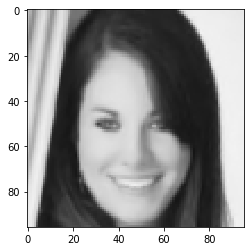

In [0]:
plt.imshow(input_images[0])

## Deep learning model
In this notebook i used diffrent models
* First model: i used pretrained VGG19 and Fine-tuning for task of dating the portraits of female students as an 83-way year-classification task between the years 1928 and 2010
* Second model : the same VGG19 model as before plus image augmentation  (horizontal mirroring data augmentation)

* Third model :I created convolution model (convolutional layer,maxpooling layer,batch normalization,dropout) with image augmentation  (horizontal mirroring data augmentation) 

### First model is so prone to Overfitting as you can see from learning curves

In [0]:
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
import keras
# create the base pre-trained model
base_model = VGG19(weights='imagenet', include_top=False,input_shape=(96,96,3))

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)

# and a logistic layer -- let's say we have 200 classes
predictions = Dense(no_labels, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional VGG19 layers
for layer in base_model.layers:
    layer.trainable = False

for layer in base_model.layers[-3:]:
    layer.trainable = True

# compile the model (should be done *after* setting layers to non-trainable)
opt=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarn

Instructions for updating:
Colocations handled automatically by placer.
80142336/80134624 [==============================] - 7s 0us/step


In [0]:
x_train = preprocess_input(input_images)


In [0]:
import keras
callbacks = [
    keras.callbacks.ModelCheckpoint('./yearbook_dating_best_model.h5', save_weights_only=True, save_best_only=True, mode='min')
]

In [0]:
model.load_weights('/content/yearbook_dating_best_model.h5')

In [0]:
history=model.fit(input_images,one_hot_labels, batch_size=16, epochs=100, callbacks=callbacks, validation_split=0.1)

Train on 13831 samples, validate on 1537 samples
Epoch 1/100
13831/13831 [==============================] - 25s 2ms/step - loss: 3.6140 - acc: 0.1078 - val_loss: 2.9442 - val_acc: 0.2043
Epoch 2/100
13831/13831 [==============================] - 22s 2ms/step - loss: 2.7060 - acc: 0.2439 - val_loss: 2.5049 - val_acc: 0.2882
Epoch 3/100
13831/13831 [==============================] - 22s 2ms/step - loss: 2.3002 - acc: 0.3342 - val_loss: 2.3064 - val_acc: 0.3474
Epoch 4/100
13831/13831 [==============================] - 22s 2ms/step - loss: 1.9874 - acc: 0.4177 - val_loss: 2.1773 - val_acc: 0.3969
Epoch 5/100
13831/13831 [==============================] - 22s 2ms/step - loss: 1.7329 - acc: 0.4827 - val_loss: 2.0645 - val_acc: 0.4229
Epoch 6/100
13831/13831 [==============================] - 22s 2ms/step - loss: 1.4971 - acc: 0.5447 - val_loss: 2.0205 - val_acc: 0.4392
Epoch 7/100
13831/13831 [==============================] - 22s 2ms/step - loss: 1.2743 - acc: 0.6010 - val_loss: 2.2173 - v

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


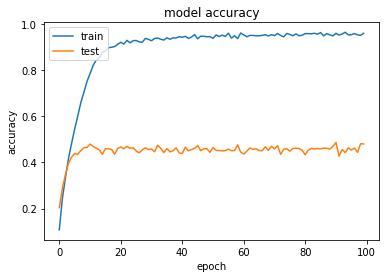

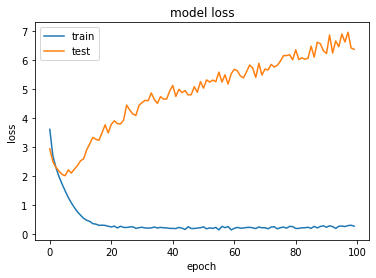

In [0]:

print(history.history.keys())

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [0]:
model.summary()

Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 96, 96, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 96, 96, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 96, 96, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 48, 48, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 48, 48, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 48, 48, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 24, 24, 128)       0  

### second model is less prone to overfitting due to image augmentation

In [0]:
import keras
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,IAAAdditiveGaussianNoise,
    IAASharpen, IAAEmboss, RandomContrast, RandomBrightness, Flip, OneOf, Compose, RandomGamma, ElasticTransform, ChannelShuffle,RGBShift, Rotate
)

class Dataset:

    
    
    def __init__(
            self,
            image_id_list,
            labels,
            no_labels,
            augmentation=None,
            preprocessing=None,
            mean=0 
    ):
        self.image_ids = image_id_list
        self.labels=labels
        self.no_labels=no_labels
        self.augmentation = augmentation
        self.preprocessing=preprocessing
        self.img_dim=(96,96)
        self.ids=image_id_list
        self.mean=mean
    def __getitem__(self, i):
        
         img=cv2.imread(self.image_ids[i])
         img = cv2.resize(img, self.img_dim, interpolation = cv2.INTER_AREA)
         img=img.reshape([self.img_dim[0],self.img_dim[1],3])

         # Add a third channel dimension to the image to make Keras happy
         #image = np.expand_dims(image, axis=2)

         # Grab the name of the letter based on the folder it was in
         min_year = 28
         one_hot=np.zeros([self.no_labels])
         year = str(self.labels[i]).split('_')[0]
         if year[0] == str(1): # 20th century
           label = int(year[-2:]) - min_year 
         else: # 21st century
           label = int(year[-2:]) + (100 - min_year)
         one_hot[label]=1
        # apply augmentations

         if self.augmentation:
            sample = self.augmentation(image=img)
            img= sample['image']
        
        # apply preprocessing
            #sample = self.preprocessing(image=image)
            #image= sample['image']
         if self.preprocessing:
           img=(img-self.mean)/255.0
        
         return img,one_hot
        
    def __len__(self):
        return len(self.ids)


class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)



def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# define heavy augmentations
def get_training_augmentation():
    train_transform = [

        #ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),
        HorizontalFlip(always_apply=False, p=0.5)
        #IAAAdditiveGaussianNoise(p=0.2),
        #IAAPerspective(p=0.5),
      
        #Lambda(mask=round_clip_0_1)
    ]
    return Compose(train_transform)

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarn

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(
    train_img_ids,train_years, random_state=2019, test_size=0.1
)

# paths.list_images(LETTER_IMAGES_FOLDER):
train_dataset = Dataset(
    X_train,
    y_train,
    no_labels,
    augmentation=get_training_augmentation(),
    preprocessing=True,
    mean=image_mean
)       

valid_dataset = Dataset(
    X_valid,
    y_valid,
    no_labels,
    augmentation=None,
    preprocessing=True,
    mean=image_mean
)
BATCH_SIZE=16
EPOCHS=30
train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)


assert train_dataloader[0][0].shape == (BATCH_SIZE, 96,96,3)
assert train_dataloader[0][1].shape == (BATCH_SIZE,83)    

In [0]:
callbacks = [
    keras.callbacks.ModelCheckpoint('./yearbook_dating_best_model01.h5', save_weights_only=True, save_best_only=True, mode='min'),
]


In [0]:
model.load_weights('/content/yearbook_dating_best_model01.h5')

In [0]:
history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

Epoch 1/30
864/864 [==============================] - 40s 46ms/step - loss: 2.0420 - acc: 0.4130 - val_loss: 2.0320 - val_acc: 0.4463
Epoch 2/30
864/864 [==============================] - 39s 45ms/step - loss: 1.7747 - acc: 0.4747 - val_loss: 2.0049 - val_acc: 0.4470
Epoch 3/30
864/864 [==============================] - 39s 45ms/step - loss: 1.6392 - acc: 0.5103 - val_loss: 2.0204 - val_acc: 0.4632
Epoch 4/30
864/864 [==============================] - 39s 45ms/step - loss: 1.5239 - acc: 0.5349 - val_loss: 2.0121 - val_acc: 0.4606
Epoch 5/30
864/864 [==============================] - 39s 45ms/step - loss: 1.4153 - acc: 0.5702 - val_loss: 2.0408 - val_acc: 0.4600
Epoch 6/30
864/864 [==============================] - 39s 45ms/step - loss: 1.3338 - acc: 0.5879 - val_loss: 2.0322 - val_acc: 0.4684
Epoch 7/30
864/864 [==============================] - 39s 45ms/step - loss: 1.2250 - acc: 0.6219 - val_loss: 2.1167 - val_acc: 0.4763
Epoch 8/30
864/864 [==============================] - 39s 45ms

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


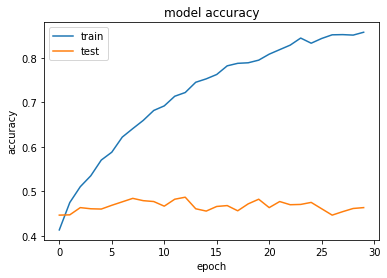

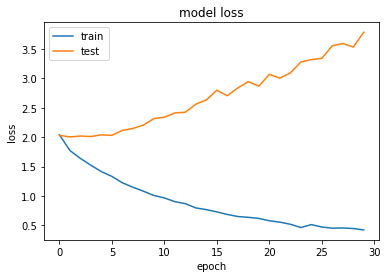

In [0]:
print(history.history.keys())

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

###Third model is less brone to overfitting due to Dropout and image augmentation

In [0]:
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Flatten, Dense
from keras.models import load_model
from keras.layers import  Dropout,BatchNormalization
def conv_model():
    model = Sequential()

    # First convolutional layer with max pooling
    model.add(Conv2D(16, (5, 5), padding="same", input_shape=(96, 96,3), activation="relu"))
    model.add(BatchNormalization(axis=1))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.2))

    # Second convolutional layer with max pooling
    model.add(Conv2D(32, (5, 5), padding="same", activation="relu"))
    model.add(BatchNormalization(axis=1))

    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.2))
    # third convolutional layer with max pooling
    model.add(Conv2D(64, (5, 5), padding="same", activation="relu"))
    model.add(BatchNormalization(axis=1))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.2))

    # fourth convolutional layer with max pooling
    model.add(Conv2D(128, (5, 5), padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.1))

    # fifth layer with 500 nodes
    model.add(Flatten())
    model.add(Dense(1024, activation="relu"))
    model.add(Dropout(0.1))
    model.add(Dense(512, activation="relu"))
    # Output layer with 32 nodes (one for each possible letter/number we predict)
    model.add(Dense(83, activation="softmax"))
    
    return model

In [0]:
model=conv_model()
opt=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
callbacks = [
    keras.callbacks.ModelCheckpoint('./yearbook_dating_best_model02.h5', save_weights_only=True, save_best_only=True, mode='min'),
]


In [0]:
model.load_weights('/content/drive/My Drive/yearbook_dating_best_model02.h5')

I retrained the model multiple time no just 30 epochs that is the output of the last attempt

In [0]:
history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

Epoch 1/30
864/864 [==============================] - 34s 39ms/step - loss: 3.7148 - acc: 0.1128 - val_loss: 3.1020 - val_acc: 0.2049
Epoch 2/30
864/864 [==============================] - 32s 37ms/step - loss: 2.9871 - acc: 0.2219 - val_loss: 2.7090 - val_acc: 0.2694
Epoch 3/30
864/864 [==============================] - 32s 37ms/step - loss: 2.6237 - acc: 0.2953 - val_loss: 2.3642 - val_acc: 0.3435
Epoch 4/30
864/864 [==============================] - 31s 36ms/step - loss: 2.3936 - acc: 0.3477 - val_loss: 2.2173 - val_acc: 0.3878
Epoch 5/30
864/864 [==============================] - 32s 37ms/step - loss: 2.1880 - acc: 0.3951 - val_loss: 2.0899 - val_acc: 0.4418
Epoch 6/30
864/864 [==============================] - 32s 36ms/step - loss: 2.0240 - acc: 0.4340 - val_loss: 2.1120 - val_acc: 0.4346
Epoch 7/30
864/864 [==============================] - 31s 36ms/step - loss: 1.8855 - acc: 0.4719 - val_loss: 2.0329 - val_acc: 0.4281
Epoch 8/30
864/864 [==============================] - 31s 36ms

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


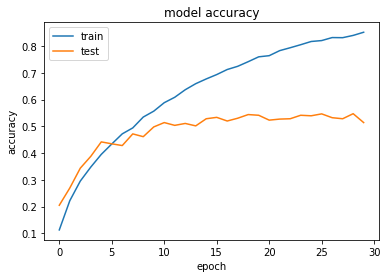

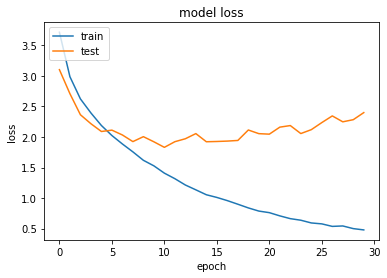

In [0]:
print(history.history.keys())

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 96, 96, 16)        1216      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 48, 48, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 48, 48, 32)        12832     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 24, 24, 64)        51264     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 12, 12, 128)      

### Evaluation of the model on the test set

In [0]:
def predictions_on_testset(model,test_img_ids,test_years,no_labels):
    no_testing_set=len(test_img_ids)
    test_images=load_images(test_img_ids,(96,96))
    test_image_mean=calculate_images_mean(test_images)
    test_images=image_pre_processing(test_images,test_image_mean)
    predictions=model.predict(test_images,16)
    predicted_labels=np.argmax(predictions,axis=1)
    test_hot=load_labels_one_hot_encoding(test_years,no_labels)
    test_labels=np.argmax(test_hot,axis=1)
    acc=np.sum(predicted_labels==test_labels)
    print("accuracy = ",acc/no_testing_set)
    diffs=abs(predicted_labels-test_labels)
    print('Avg Error', np.average(diffs))
    print('Median Error', np.median(diffs))
    print('Class. Accuracy Within 5 Years', (np.sum(diffs<5))/(no_testing_set) )
    print('Class. Accuracy Within 10 Years',np.sum(diffs<10)/(no_testing_set))



In [0]:
predictions_on_testset(model,test_img_ids,test_years,no_labels)

accuracy =  0.05418835778513961
Avg Error 10.788215806909607
Median Error 6.0
Class. Accuracy Within 5 Years 0.39446284902981543
Class. Accuracy Within 10 Years 0.6218646474207288
